In [1]:
import numpy as np
import random
import sklearn.linear_model as linear
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import sklearn.model_selection as selection
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn import metrics

import torch as th
import torch.nn as nn
import torch.optim as optim
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
databasePath = "../eICU/training/"
exportPath = "../eICU/training/"

In [3]:
finalFeatures = pd.read_csv(databasePath + '/finalFeatures.csv')
finalFeatures = finalFeatures.fillna(0) # fills nan from kurtosis and skew
finalFeatures

,patientid,temperature_min,temperature_max,temperature_mean,temperature_std,temperature_kurtosis,temperature_skew,temperature_median,heartrate_min,heartrate_max,...,creatinine_skew,creatinine_median,urineoutputbyweight_min,urineoutputbyweight_max,urineoutputbyweight_mean,urineoutputbyweight_std,urineoutputbyweight_kurtosis,urineoutputbyweight_skew,urineoutputbyweight_median,diagnosis
0,1412030,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,68.0,120.0,...,-1.4140,0.6875,6.9586,6.9586,6.9586,0.0000,0.0000,0.0000,6.9586,0.0
1,1412271,37.6965,38.1204,38.0819,0.1278,11.0000,-3.3166,38.1204,103.0,112.0,...,0.2131,1.4000,2.4331,2.4331,2.4331,0.0000,0.0000,0.0000,2.4331,1.0
2,1412290,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,57.0,75.0,...,0.1274,1.2345,4.4543,4.4543,4.4543,0.0000,0.0000,0.0000,4.4543,0.0
3,1412660,37.4000,38.0000,37.7832,0.1822,-0.3726,-0.6013,37.8000,84.0,109.0,...,-0.5963,1.6136,0.8306,3.7375,3.6347,0.4814,21.5211,-4.7383,3.7375,0.0
4,1412840,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,70.0,106.0,...,-0.0575,1.0584,0.6420,1.7976,1.5475,0.2748,2.0620,-1.6282,1.5956,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199338,33532516,32.2000,37.7000,35.3112,2.1057,-1.7574,-0.2178,36.6000,51.0,104.0,...,-0.0645,2.6469,0.0980,5.6373,1.0889,0.9895,3.4195,1.6831,0.8171,1.0
199339,33532517,32.2000,37.4000,34.5467,1.8862,-1.7703,0.2656,33.4000,51.0,104.0,...,0.1481,2.5493,0.0980,5.6373,0.9832,1.0570,3.9619,1.9491,0.6334,1.0
199340,33532518,32.2000,36.8000,34.1643,1.7398,-1.4068,0.6213,33.1000,60.0,104.0,...,0.0064,2.4888,0.0980,5.6373,1.0385,1.1231,2.9569,1.7434,0.6010,1.0
199341,33532540,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,72.0,83.0,...,-2.1039,2.2769,0.3576,19.0703,3.7475,2.6719,13.1009,3.2470,2.3838,0.0


#### Cleaning data and Sorting to Input and Target Arrays

In [4]:
X = [] # input (attributes)
y = [] # output (targets)

X = finalFeatures.iloc[:, 1:57].values
y = finalFeatures.iloc[:, 57].values


#### Setting up Models for Neural Network

In [5]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_func = nn.BCELoss()

    def forward(self, x):
        return None

    def loss(self, x, y):
        probs = self.forward(x)
        return self.loss_func(probs, y)

    def predict_proba(self, x, as_numpy=False):
        res = self.forward(x)
        if as_numpy:
            res = res.cpu().detach().numpy()
        return res

    def predict(self, x, threshold=0.5, as_numpy=False):
        probs = self.predict_proba(x, as_numpy)
        return probs > threshold

    def fit(self, x_train, x_test, y_train, y_test, epochs=1000, lr=0.1, lam=0):
        optimizer = optim.RMSprop(self.parameters(), lr=lr)
        train_loss_curve = []
        test_loss_curve = []
        for epoch in range(epochs):
            optimizer.zero_grad()
            train_loss_val = self.loss(x_train, y_train) + self.regularize(lam)
            train_loss_curve.append(train_loss_val.data.item())
            train_loss_val.backward()
            optimizer.step()
            
            test_loss_val = self.loss(x_test, y_test) + self.regularize(lam)
            test_loss_curve.append(test_loss_val.data.item())
            
            if epoch % 500 == 0:
                print(f'Epoch {epoch}, Train Loss: {train_loss_val:.5f}, Test Loss: {test_loss_val:.5f}')
            
            
        return train_loss_curve, test_loss_curve

    def regularize(self, lam):
        loss_val = 0
        for p in self.parameters():
            loss_val += lam * th.norm(p)
        return loss_val

In [6]:
class FeedForwardModel(Model):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(56, 113, bias=True)
        self.act1 = nn.PReLU()
        self.l2 = nn.Linear(113, 56, bias=True)
        self.act2 = nn.PReLU()
        self.l3 = nn.Linear(56, 1, bias=True)
        self.act3 = nn.Sigmoid()

    def get_intermediary(self, x):
        res = self.l1(x)
        res = self.act1(res)
        res = self.l2(res)
        res = self.act2(res)

        return res

    def forward(self, X):
        res = self.get_intermediary(X)
        res = self.l3(res)
        res = self.act3(res)
        return res

#### Applying Classifiers and Neural Network Model

In [7]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
def random_guessing(inputs):
    prediction = []
    
    for values in inputs:
        prediction.append(random.randint(0, 1))
        
    return prediction

In [9]:
def random_guessing(inputs):
    prediction = []
    
    for values in inputs:
        prediction.append(random.randint(0, 1))
        
    return prediction

In [10]:
kf = selection.KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X)

f1_lr = []
f1_nn = []
f1_rf = []
f1_gnb = []
f1_rand = []

precision_lr = []
precision_nn = []
precision_rf = []
precision_gnb = []
precision_rand = []

accuracy_lr = []
accuracy_nn = []
accuracy_rf = []
accuracy_gnb = []
accuracy_rand = []

recall_lr = []
recall_nn = []
recall_rf = []
recall_gnb = []
recall_rand = []

ras_lr = []
ras_nn = []
ras_rf = []
ras_gnb = []
ras_rand = []

train_curve = []
test_curve = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)


    lr = linear.LogisticRegression(solver='lbfgs')
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_test)
    probs = lr.predict_proba(X_test)[:,1]
    f1_lr.append(metrics.f1_score(y_test, predictions))
    precision_lr.append(metrics.precision_score(y_test, predictions))
    accuracy_lr.append(metrics.accuracy_score(y_test, predictions))
    recall_lr.append(metrics.recall_score(y_test, predictions))
    ras_lr.append(metrics.roc_auc_score(y_test, predictions))
    
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_test)
    probs = rf.predict_proba(X_test)[:,1]
    f1_rf.append(metrics.f1_score(y_test, predictions))
    precision_rf.append(metrics.precision_score(y_test, predictions))
    accuracy_rf.append(metrics.accuracy_score(y_test, predictions))
    recall_rf.append(metrics.recall_score(y_test, predictions))
    ras_rf.append(metrics.roc_auc_score(y_test, predictions))
    
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    predictions = gnb.predict(X_test)
    probs = gnb.predict_proba(X_test)[:,1]
    f1_gnb.append(metrics.f1_score(y_test, predictions))
    precision_gnb.append(metrics.precision_score(y_test, predictions))
    accuracy_gnb.append(metrics.accuracy_score(y_test, predictions))
    recall_gnb.append(metrics.recall_score(y_test, predictions))
    ras_gnb.append(metrics.roc_auc_score(y_test, predictions))
    
    predictions = random_guessing(X_test)
    f1_rand.append(metrics.f1_score(y_test, predictions))
    precision_rand.append(metrics.precision_score(y_test, predictions))
    accuracy_rand.append(metrics.accuracy_score(y_test, predictions))
    recall_rand.append(metrics.recall_score(y_test, predictions))
    ras_rand.append(metrics.roc_auc_score(y_test, predictions))
    
    X_train = th.tensor(X_train, dtype=th.float32)
    X_test = th.tensor(X_test, dtype=th.float32)
    y_train = th.tensor(y_train, dtype=th.float32).view(-1, 1)
    y_test = th.tensor(y_test, dtype=th.float32).view(-1, 1)

    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    ffnn = FeedForwardModel()
    ffnn.to(device)

    train_loss, test_loss = ffnn.fit(X_train, X_test, y_train, y_test, epochs=4000, lr=0.0002, lam=0.0001)
    
    train_curve.append(train_loss)
    test_curve.append(test_loss)
    
    predictions = ffnn.predict(X_test, as_numpy=True)
    probs = ffnn.predict_proba(X_test, as_numpy=True)
    
    f1_nn.append(metrics.f1_score(y_test.cpu(), predictions))
    precision_nn.append(metrics.precision_score(y_test.cpu(), predictions))
    accuracy_nn.append(metrics.accuracy_score(y_test.cpu(), predictions))
    recall_nn.append(metrics.recall_score(y_test.cpu(), predictions))
    ras_nn.append(metrics.roc_auc_score(y_test.cpu(), predictions))

Epoch 0, Train Loss: 0.68685, Test Loss: 0.68053
Epoch 500, Train Loss: 0.36424, Test Loss: 0.35911
Epoch 1000, Train Loss: 0.25442, Test Loss: 0.25043
Epoch 1500, Train Loss: 0.20891, Test Loss: 0.20413
Epoch 2000, Train Loss: 0.18501, Test Loss: 0.18254
Epoch 2500, Train Loss: 0.17017, Test Loss: 0.16839
Epoch 3000, Train Loss: 0.15972, Test Loss: 0.15817
Epoch 3500, Train Loss: 0.15105, Test Loss: 0.14982
Epoch 0, Train Loss: 0.68187, Test Loss: 0.67558
Epoch 500, Train Loss: 0.33990, Test Loss: 0.34081
Epoch 1000, Train Loss: 0.24207, Test Loss: 0.24200
Epoch 1500, Train Loss: 0.20863, Test Loss: 0.20975
Epoch 2000, Train Loss: 0.19269, Test Loss: 0.19528
Epoch 2500, Train Loss: 0.18282, Test Loss: 0.19141
Epoch 3000, Train Loss: 0.17434, Test Loss: 0.18213
Epoch 3500, Train Loss: 0.17025, Test Loss: 0.17577
Epoch 0, Train Loss: 0.69825, Test Loss: 0.68866
Epoch 500, Train Loss: 0.36660, Test Loss: 0.36643
Epoch 1000, Train Loss: 0.26293, Test Loss: 0.26084
Epoch 1500, Train Loss: 

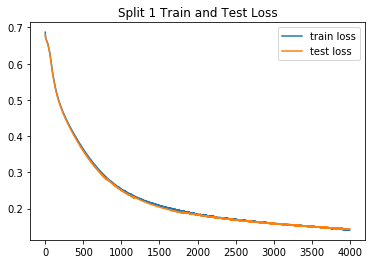

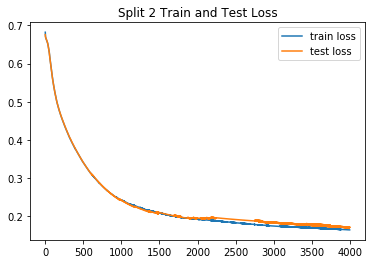

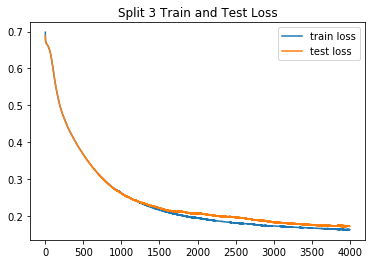

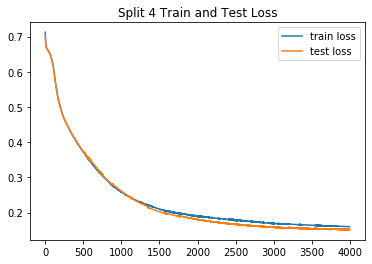

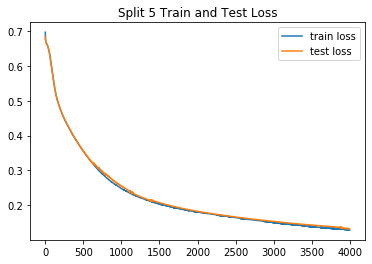

In [11]:
for i in range(len(train_curve)):
    plt.plot(train_curve[i], label='train loss')
    plt.plot(test_curve[i], label='test loss')
    plt.legend()
    plt.title(f'Split {str(i+1)} Train and Test Loss')
    plt.show()

In [12]:
def plot_loss(loss_curve, i):
    plt.plot(list(range(len(loss_curve))), loss_curve, label=f'Split {i+1}')

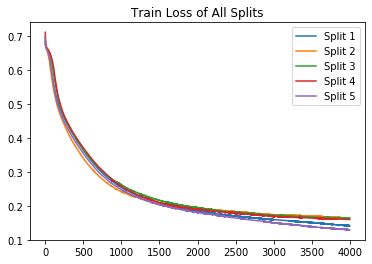

In [13]:
for i, curve in enumerate(train_curve):
    plot_loss(curve, i)

plt.legend()
plt.title('Train Loss of All Splits')
plt.show()

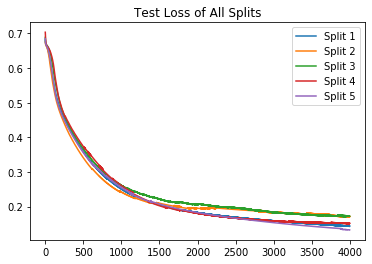

In [14]:
for i, curve in enumerate(test_curve):
    plot_loss(curve, i)

plt.legend()
plt.title('Test Loss of All Splits')
plt.show()

#### Comparing Statistical Results for the Models

In [15]:
print("Random Guessing Model F1 Score Mean: ", np.mean(f1_rand))
print("Random Guessing Model F1 Score Standard Deviation: ", np.std(f1_rand), '\n')

print("Random Guessing Model Precision Score Mean: ", np.mean(precision_rand))
print("Random Guessing Model Precision Score Standard Deviation: ", np.std(precision_rand), '\n')

print("Random Guessing Model Accuracy Score Mean: ", np.mean(accuracy_rand))
print("Random Guessing Model Accuracy Score Standard Deviation: ", np.std(accuracy_rand), '\n')

print("Random Guessing Model Recall Score Mean: ", np.mean(recall_rand))
print("Random Guessing Model Recall Score Standard Deviation: ", np.std(recall_rand), '\n')

print("Random Guessing Model ROC AUC Score Mean: ", np.mean(ras_rand))
print("Random Guessing Model ROC AUC Score Standard Deviation: ", np.std(ras_rand))

Random Guessing Model F1 Score Mean:  0.4378253024487754
Random Guessing Model F1 Score Standard Deviation:  0.0007632103640731181 

Random Guessing Model Precision Score Mean:  0.3893291966740523
Random Guessing Model Precision Score Standard Deviation:  0.0012742628247831343 

Random Guessing Model Accuracy Score Mean:  0.5005493154372735
Random Guessing Model Accuracy Score Standard Deviation:  0.0010516569290438603 

Random Guessing Model Recall Score Mean:  0.5001292504448627
Random Guessing Model Recall Score Standard Deviation:  0.0013611277788971557 

Random Guessing Model ROC AUC Score Mean:  0.5004726721848057
Random Guessing Model ROC AUC Score Standard Deviation:  0.0006689116630721621


In [16]:
print("Logistic Regression Model F1 Score Mean: ", np.mean(f1_lr))
print("Logistic Regression Model F1 Score Standard Deviation: ", np.std(f1_lr), '\n')

print("Logistic Regression Model Precision Score Mean: ", np.mean(precision_lr))
print("Logistic Regression Model Precision Score Standard Deviation: ", np.std(precision_lr), '\n')

print("Logistic Regression Model Accuracy Score Mean: ", np.mean(accuracy_lr))
print("Logistic Regression Model Accuracy Score Standard Deviation: ", np.std(accuracy_lr), '\n')

print("Logistic Regression Model Recall Score Mean: ", np.mean(recall_lr))
print("Logistic Regression Model Recall Score Standard Deviation: ", np.std(recall_lr), '\n')

print("Logistic Regression Model ROC AUC Score Mean: ", np.mean(ras_lr))
print("Logistic Regression Model ROC AUC Score Standard Deviation: ", np.std(ras_lr))

Logistic Regression Model F1 Score Mean:  0.9318978091092767
Logistic Regression Model F1 Score Standard Deviation:  0.0007276291372975994 

Logistic Regression Model Precision Score Mean:  0.9643990860379406
Logistic Regression Model Precision Score Standard Deviation:  0.0007729292709895077 

Logistic Regression Model Accuracy Score Mean:  0.9487616800545012
Logistic Regression Model Accuracy Score Standard Deviation:  0.00039123751582889415 

Logistic Regression Model Recall Score Mean:  0.9015179246587142
Logistic Regression Model Recall Score Standard Deviation:  0.001554673571464573 

Logistic Regression Model ROC AUC Score Mean:  0.9401695280045997
Logistic Regression Model ROC AUC Score Standard Deviation:  0.0006296033872167019


In [17]:
print("Random Forest Model F1 Score Mean: ", np.mean(f1_rf))
print("Random Forest Model F1 Score Standard Deviation: ", np.std(f1_rf), '\n')

print("Random Forest Model Precision Score Mean: ", np.mean(precision_rf))
print("Random Forest Model Precision Score Standard Deviation: ", np.std(precision_rf), '\n')

print("Random Forest Model Accuracy Score Mean: ", np.mean(accuracy_rf))
print("Random Forest Model Accuracy Score Standard Deviation: ", np.std(accuracy_rf), '\n')

print("Random Forest Model Recall Score Mean: ", np.mean(recall_rf))
print("Random Forest Model Recall Score Standard Deviation: ", np.std(recall_rf), '\n')

print("Random Forest Model ROC AUC Score Mean: ", np.mean(ras_rf))
print("Random Forest Model ROC AUC Score Standard Deviation: ", np.std(ras_rf), '\n')

Random Forest Model F1 Score Mean:  0.9951066397952294
Random Forest Model F1 Score Standard Deviation:  0.00030307541677225915 

Random Forest Model Precision Score Mean:  0.9908943120483429
Random Forest Model Precision Score Standard Deviation:  0.0005951379786558553 

Random Forest Model Accuracy Score Mean:  0.9961774423708801
Random Forest Model Accuracy Score Standard Deviation:  0.00024401541162806365 

Random Forest Model Recall Score Mean:  0.9993551526088919
Random Forest Model Recall Score Standard Deviation:  0.00020318108173313074 

Random Forest Model ROC AUC Score Mean:  0.996755084555744
Random Forest Model ROC AUC Score Standard Deviation:  0.0002130762936544947 



In [18]:
print("Gaussian Naive Bayes Model F1 Score Mean: ", np.mean(f1_gnb))
print("Gaussian Naive Bayes Model F1 Score Standard Deviation: ", np.std(f1_gnb), '\n')

print("Gaussian Naive Bayes Model Precision Score Mean: ", np.mean(precision_gnb))
print("Gaussian Naive Bayes Model Precision Score Standard Deviation: ", np.std(precision_gnb), '\n')

print("Gaussian Naive Bayes Model Accuracy Score Mean: ", np.mean(accuracy_gnb))
print("Gaussian Naive Bayes Model Accuracy Score Standard Deviation: ", np.std(accuracy_gnb), '\n')

print("Gaussian Naive Bayes Model Recall Score Mean: ", np.mean(recall_gnb))
print("Gaussian Naive Bayes Model Recall Score Standard Deviation: ", np.std(recall_gnb), '\n')

print("Gaussian Naive Bayes Model ROC AUC Score Mean: ", np.mean(ras_gnb))
print("Gaussian Naive Bayes Model ROC AUC Score Standard Deviation: ", np.std(ras_gnb), '\n')

Gaussian Naive Bayes Model F1 Score Mean:  0.8626259710628856
Gaussian Naive Bayes Model F1 Score Standard Deviation:  0.005206746145670816 

Gaussian Naive Bayes Model Precision Score Mean:  0.865488961485771
Gaussian Naive Bayes Model Precision Score Standard Deviation:  0.010188237778533978 

Gaussian Naive Bayes Model Accuracy Score Mean:  0.893530234715241
Gaussian Naive Bayes Model Accuracy Score Standard Deviation:  0.0019065082243723461 

Gaussian Naive Bayes Model Recall Score Mean:  0.8603053353749985
Gaussian Naive Bayes Model Recall Score Standard Deviation:  0.019955870746640802 

Gaussian Naive Bayes Model ROC AUC Score Mean:  0.8874574157814766
Gaussian Naive Bayes Model ROC AUC Score Standard Deviation:  0.005175454374640857 



In [19]:
print("Neural Network Model F1 Score Mean: ", np.mean(f1_nn))
print("Neural Network Model F1 Score Standard Deviation: ", np.std(f1_nn), '\n')

print("Neural Network Model Precision Score Mean: ", np.mean(precision_nn))
print("Neural Network Model Precision Score Standard Deviation: ", np.std(precision_nn), '\n')

print("Neural Network Model Accuracy Score Mean: ", np.mean(accuracy_nn))
print("Neural Network Model Accuracy Score Standard Deviation: ", np.std(accuracy_nn), '\n')

print("Neural Network Model Recall Score Mean: ", np.mean(recall_nn))
print("Neural Network Model Recall Score Standard Deviation: ", np.std(ras_nn), '\n')

print("Neural Network Model ROC AUC Score Mean: ", np.mean(ras_nn))
print("Neural Network Model ROC AUC Score Standard Deviation: ", np.std(ras_nn), '\n')

Neural Network Model F1 Score Mean:  0.941330220240298
Neural Network Model F1 Score Standard Deviation:  0.004880386839449699 

Neural Network Model Precision Score Mean:  0.9551118272684376
Neural Network Model Precision Score Standard Deviation:  0.010675606270235916 

Neural Network Model Accuracy Score Mean:  0.9550523756412919
Neural Network Model Accuracy Score Standard Deviation:  0.0031304551529641785 

Neural Network Model Recall Score Mean:  0.9283783723467215
Neural Network Model Recall Score Standard Deviation:  0.005811447649448112 

Neural Network Model ROC AUC Score Mean:  0.9502009981504322
Neural Network Model ROC AUC Score Standard Deviation:  0.005811447649448112 



In [20]:
resultdf = pd.DataFrame(columns=['Classifiers', 'F1 Score', 'Accuracy Score', 'Precision Score', 'Recall Score', 'ROC AUC Score'])

resultdf.loc[0] = 'Random Guessing', np.mean(f1_rand), np.mean(accuracy_rand), np.mean(precision_rand), np.mean(recall_rand),  np.mean(ras_rand)
resultdf.loc[1] = 'Logistic Regression', np.mean(f1_lr), np.mean(accuracy_lr), np.mean(precision_lr), np.mean(recall_lr),  np.mean(ras_lr)
resultdf.loc[2] = 'Neural Network', np.mean(f1_nn), np.mean(accuracy_nn), np.mean(precision_nn), np.mean(recall_nn),  np.mean(ras_nn)
resultdf.loc[3] = 'Random Forest', np.mean(f1_rf), np.mean(accuracy_rf), np.mean(precision_rf), np.mean(recall_rf),  np.mean(ras_rf)
resultdf.loc[4] = 'Gaussian Naive Bayes ', np.mean(f1_gnb), np.mean(accuracy_gnb), np.mean(precision_gnb), np.mean(recall_gnb),  np.mean(ras_gnb)

resultdf

,Classifiers,F1 Score,Accuracy Score,Precision Score,Recall Score,ROC AUC Score
0,Random Guessing,0.437825,0.500549,0.389329,0.500129,0.500473
1,Logistic Regression,0.931898,0.948762,0.964399,0.901518,0.940170
2,Neural Network,0.941330,0.955052,0.955112,0.928378,0.950201
3,Random Forest,0.995107,0.996177,0.990894,0.999355,0.996755
4,Gaussian Naive Bayes,0.862626,0.893530,0.865489,0.860305,0.887457


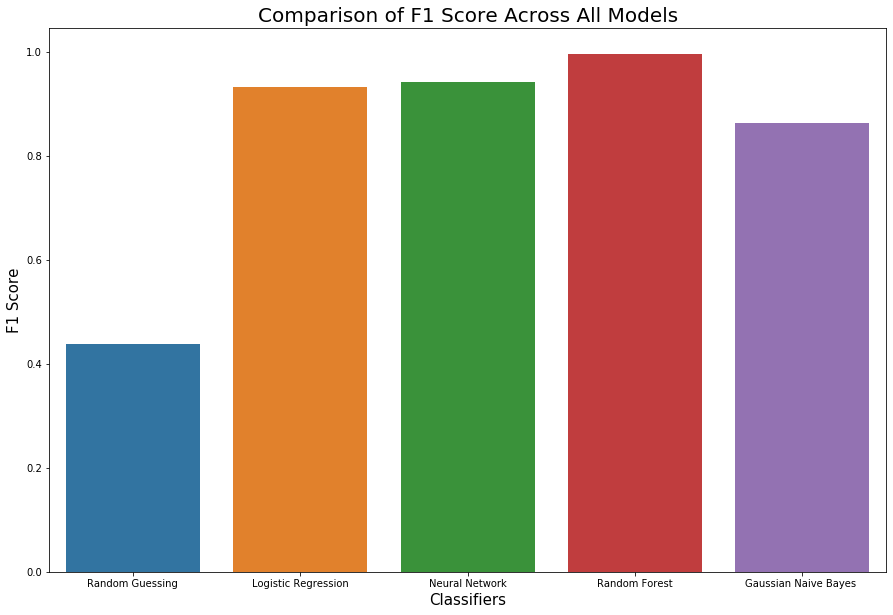

In [21]:
plt.figure(figsize=(15,10))
sns.barplot(data=resultdf, x='Classifiers', y='F1 Score')
plt.title('Comparison of F1 Score Across All Models', fontsize=20)
plt.xlabel("Classifiers", fontsize=15)
plt.ylabel("F1 Score", fontsize=15)
plt.show()

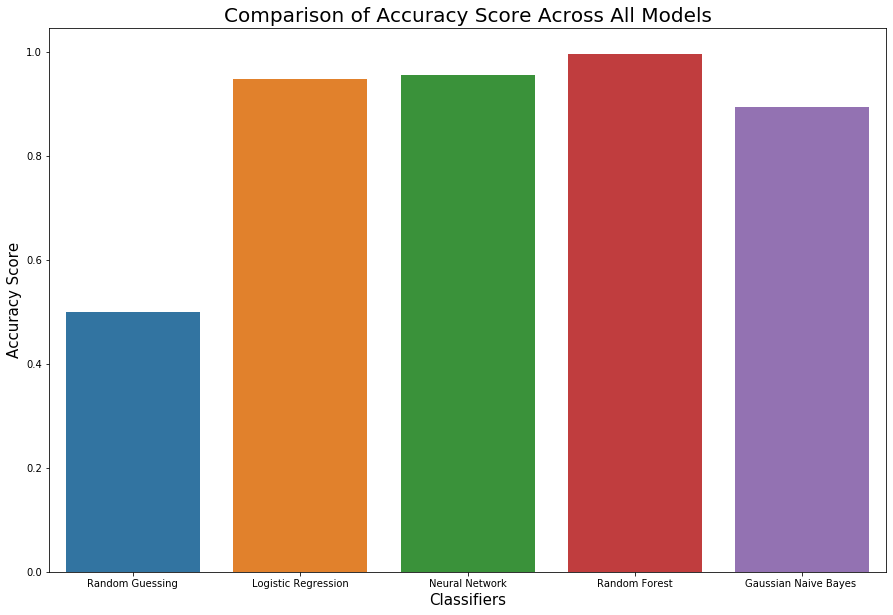

In [22]:
plt.figure(figsize=(15,10))
sns.barplot(data=resultdf, x='Classifiers', y='Accuracy Score')
plt.title('Comparison of Accuracy Score Across All Models', fontsize=20)
plt.xlabel("Classifiers", fontsize=15)
plt.ylabel("Accuracy Score", fontsize=15)
plt.show()

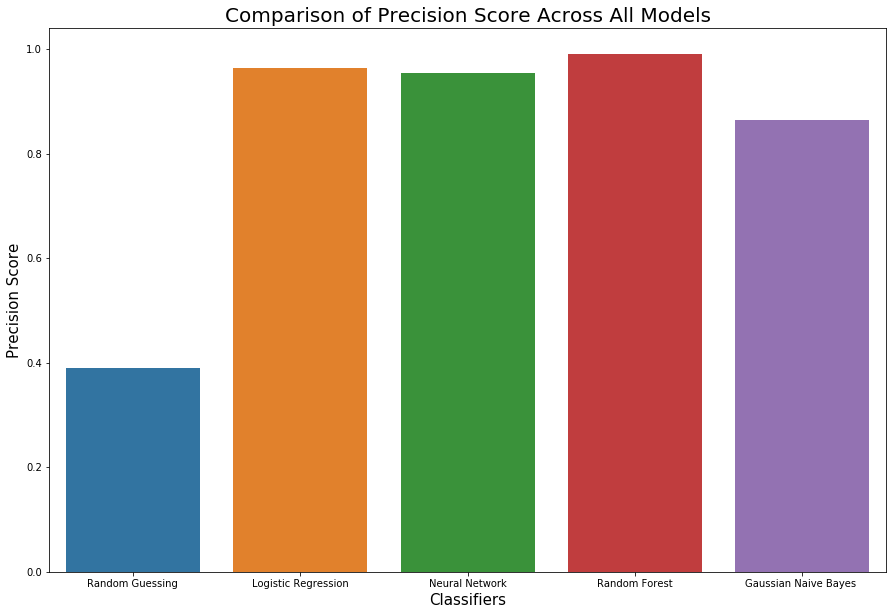

In [23]:
plt.figure(figsize=(15,10))
sns.barplot(data=resultdf, x='Classifiers', y='Precision Score')
plt.title('Comparison of Precision Score Across All Models', fontsize=20)
plt.xlabel("Classifiers", fontsize=15)
plt.ylabel("Precision Score", fontsize=15)
plt.show()

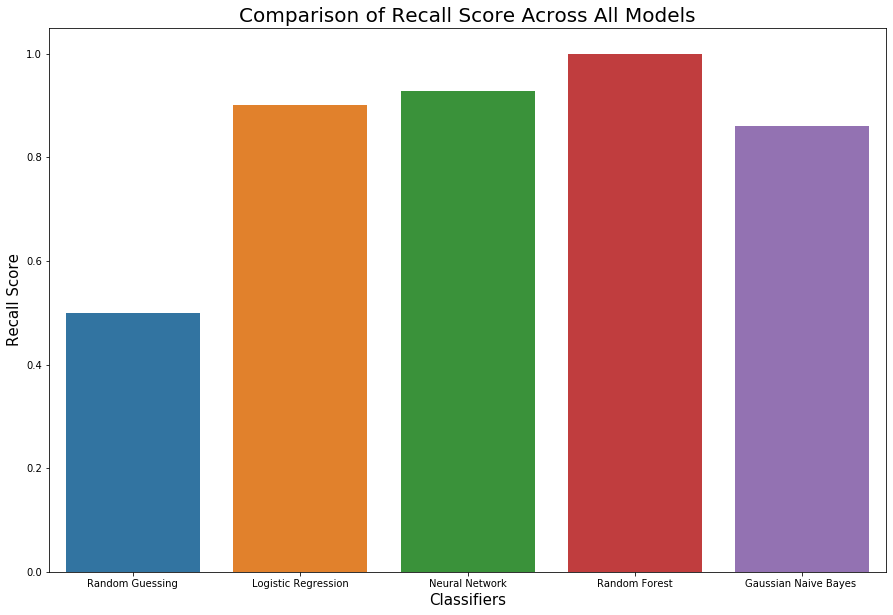

In [24]:
plt.figure(figsize=(15,10))
sns.barplot(data=resultdf, x='Classifiers', y='Recall Score')
plt.title('Comparison of Recall Score Across All Models', fontsize=20)
plt.xlabel("Classifiers", fontsize=15)
plt.ylabel("Recall Score", fontsize=15)
plt.show()

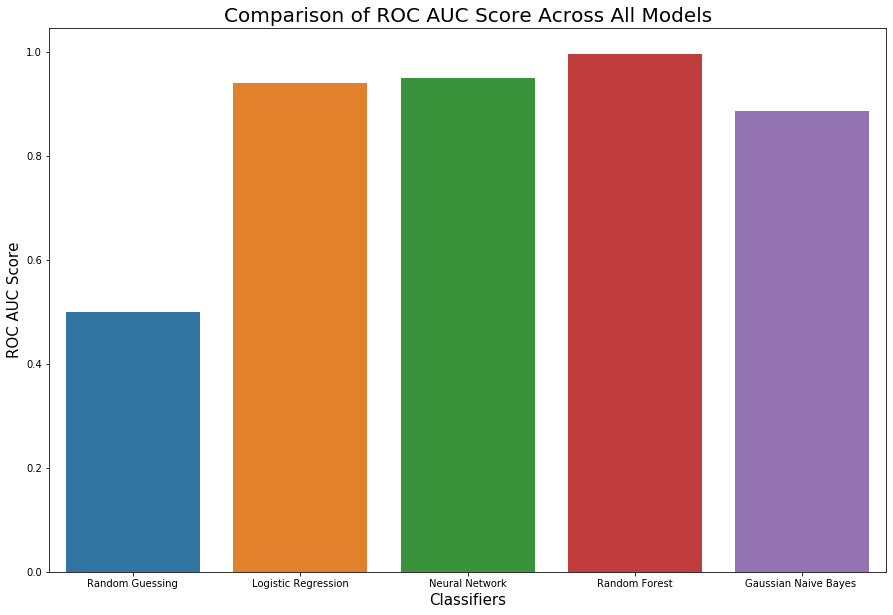

In [25]:
plt.figure(figsize=(15,10))
sns.barplot(data=resultdf, x='Classifiers', y='ROC AUC Score')
plt.title('Comparison of ROC AUC Score Across All Models', fontsize=20)
plt.xlabel("Classifiers", fontsize=15)
plt.ylabel("ROC AUC Score", fontsize=15)
plt.show()

#### Intermediary Workings of the Neural Network

In [26]:
X_transformed = th.tensor(X, dtype=th.float32)
representations = ffnn.get_intermediary(X_transformed.to(device))
representations = representations.cpu().detach().numpy()

In [ ]:
colors = np.array(['tab:red' if cl == 0 else 'tab:blue' for cl in y])
plt.scatter(representations[:,10], representations[:,26], c=colors)
plt.show()

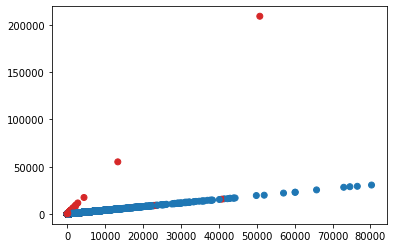